In [14]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

In [15]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name = 'C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels, C, axis = 0)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    return one_hot

In [4]:
## function test
labels = np.array([1,0,1,1,0])
one_hot = one_hot_matrix(labels, C = 2)
print ("one_hot = " + str(one_hot))

one_hot = [[0. 1. 0. 0. 1.]
 [1. 0. 1. 1. 0.]]


In [62]:
# input file path
filename = r'D:\wkspacePY\STA 141C\data\processed.csv'
# load and split data
df = pd.read_csv(filename, index_col='shot_id')
# training set
# X_train: training matrix
# Y_train: true label of training matrix
# test set
# X_test: test matrix
# Y_test: true label of test matrix
Y = df['shot_made_flag']
X = df.drop(['shot_made_flag'], axis=1)
Y = Y.as_matrix()
X = X.as_matrix()
# max_X = np.array([np.linalg.norm(X[:, i]) for i in range(X.shape[1])]).reshape(1, X.shape[1])
max_X = np.array([np.max(X[:, i]) for i in range(X.shape[1])]).reshape(1, X.shape[1])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
# Normalize
X_train /= max_X
X_test /= max_X
# Transpose
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T
# convert to one_hot
Y_train = one_hot_matrix(Y_train, C = 2)
Y_test = one_hot_matrix(Y_test, C = 2)
# print info
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 17987
number of test examples = 7710
X_train shape: (116, 17987)
Y_train shape: (2, 17987)
X_test shape: (116, 7710)
Y_test shape: (2, 7710)


In [53]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape = [n_x,None])
    Y = tf.placeholder(tf.float32, shape = [n_y,None])
    
    return X, Y

In [6]:
## function test
tf.reset_default_graph()
X, Y = create_placeholders(X_train.shape[0], Y_train.shape[0])
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(4, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(2, ?), dtype=float32)


In [54]:
def initialize_parameters(nn):
    """
    layer = len(nn)-1
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [n1, n0]
                        b1 : [n1, 1]
                        W2 : [n2, n1]
                        b2 : [n2, 1]
                        ...
                        W_layer : [n(layer), n(layer-1)]
                        b_layer : [n(layer), 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, ...
    """
    parameters = {}
    for i in range(len(nn)-1):
        parameters['W' + str(i+1)] = tf.get_variable('W'+str(i+1), [nn[i+1], nn[i]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        parameters['b' + str(i+1)] = tf.get_variable('b' + str(i+1), [nn[i+1],1], initializer = tf.zeros_initializer())

    return parameters

In [8]:
## function test
tf.reset_default_graph()
neural_num = [X_train.shape[0], 25, 12, 2]
parameters = {}
with tf.Session() as sess:
    parameters = initialize_parameters(neural_num)
print(parameters)

{'W1': <tf.Variable 'W1:0' shape=(25, 4) dtype=float32_ref>, 'b1': <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>, 'b2': <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>, 'W3': <tf.Variable 'W3:0' shape=(2, 12) dtype=float32_ref>, 'b3': <tf.Variable 'b3:0' shape=(2, 1) dtype=float32_ref>}


In [55]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", ...
                  the shapes are given in initialize_parameters

    Returns: 
    Z(len(parameters)/2) -- the output of the last LINEAR unit
    """
    length = int(len(parameters)/2)
    Z = tf.add(tf.matmul(parameters['W1'], X),parameters['b1'])
    A = tf.nn.relu(Z)  
    for i in range(2, length):
        Z = tf.add(tf.matmul(parameters['W'+str(i)], A),parameters['b'+str(i)])
        A = tf.nn.relu(Z)  
    Z = tf.add(tf.matmul(parameters['W'+str(length)], A),parameters['b'+str(length)])
    return Z

In [10]:
## function test
tf.reset_default_graph()
neural_num = [X_train.shape[0], 25, 12, 2]
parameters = {}
with tf.Session() as sess:
    X, Y = create_placeholders(116, 1)
    parameters = initialize_parameters(neural_num)
    Z3 = forward_propagation(X, parameters)
    print("Z_3 = " + str(Z3))

ValueError: Dimensions must be equal, but are 4 and 116 for 'MatMul' (op: 'MatMul') with input shapes: [25,4], [116,?].

In [56]:
def compute_cost(Z_end, Y):
    """
    Computes the cost
    
    Arguments:
    Z_end -- output of forward propagation (output of the last LINEAR unit), of shape (1, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z_end
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z_end)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [12]:
## function test
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(116, 1)
    parameters = initialize_parameters(neural_num)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [21]:
# discarded
def random_mini_batches(X_train, Y_train, minibatch_size, seed):
    tf.set_random_seed(seed)
    start = 0
    interval = minibatch_size
    data = np.vstack((Y_train, X_train))
    np.random.shuffle(data)
    end = start + interval
    train_data = []
    for i in range(minibatch_size):
        if start >= X_train.shape[1]:
            break
        if end < X_train.shape[1]:
            y = data[0:Y_train.shape[0], start:end]
            x = data[Y_train.shape[0]:, start:end]
        else:
            y = data[0:Y_train.shape[0], start:]
            x = data[Y_train.shape[0]:, start:]
        train_data.append((x,y))
        start = end
        end = start + interval
    return train_data

In [14]:
## function test
tf.reset_default_graph()
train_data = random_mini_batches(X_train, Y_train, X_train.shape[1], 2)
train_data[0][0].shape

(116, 20557)

In [57]:
def model(X_train, Y_train, X_test, Y_test, nn, learning_rate = 0.0001,
          num_epochs = 1500, print_cost = True, figname = 'c:/', period = 2000):
    """
    Implements a len(nn)-1 layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->...->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set
    Y_train -- test set
    X_test -- training set
    Y_test -- test set
    nn -- input layer + number of neurals in each layer
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    # seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x,n_y)

    # Initialize parameters
    parameters = initialize_parameters(nn)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z_end = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z_end, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:  
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            if epoch%period == 0:
                learning_rate *= 0.1
                optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
            _ , tmp_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
            epoch_cost = tmp_cost
            
            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.savefig(figname)
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        correct_prediction = tf.equal(tf.argmax(Z_end), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 0.734075
Cost after epoch 100: 0.680884
Cost after epoch 200: 0.674853
Cost after epoch 300: 0.667094
Cost after epoch 400: 0.659555
Cost after epoch 500: 0.655167
Cost after epoch 600: 0.653536
Cost after epoch 700: 0.652881
Cost after epoch 800: 0.652513
Cost after epoch 900: 0.652225
Cost after epoch 1000: 0.651949
Cost after epoch 1100: 0.651721
Cost after epoch 1200: 0.651536
Cost after epoch 1300: 0.651379
Cost after epoch 1400: 0.651276
Cost after epoch 1500: 0.651190
Cost after epoch 1600: 0.651112
Cost after epoch 1700: 0.651040
Cost after epoch 1800: 0.650970
Cost after epoch 1900: 0.650910
Cost after epoch 2000: 0.650855
Cost after epoch 2100: 0.650803
Cost after epoch 2200: 0.650759
Cost after epoch 2300: 0.650719
Cost after epoch 2400: 0.650684
Cost after epoch 2500: 0.650650
Cost after epoch 2600: 0.650618
Cost after epoch 2700: 0.650590
Cost after epoch 2800: 0.650562
Cost after epoch 2900: 0.650537
Cost after epoch 3000: 0.650513
Cost after epoch 310

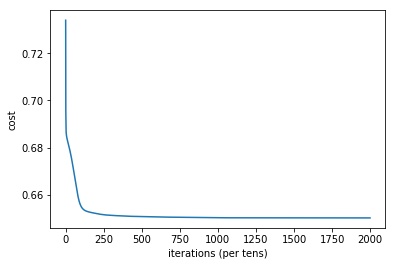

Parameters have been trained!
Train Accuracy: 0.6075499
Test Accuracy: 0.5996109
Neural network training time consumed: 287.755611 secs


In [58]:
## training and predict
tf.reset_default_graph()
start_time = time.time()
neural_num = [X_train.shape[0], 25, 12, 2]
# cost function of mini_batch may not decrease at each iteration
figname = r'D:\wkspacePY\STA 141C\picture\nn3_feature_10000'
parameters = model(X_train, Y_train, X_test, Y_test, neural_num, num_epochs = 10000, learning_rate = 1, figname = figname, period = 5000)
end_time = time.time()
print("Neural network training time consumed: %lf secs" % (end_time - start_time))

Cost after epoch 0: 0.710124
Cost after epoch 100: 0.664817
Cost after epoch 200: 0.655584
Cost after epoch 300: 0.653512
Cost after epoch 400: 0.652876
Cost after epoch 500: 0.652488
Cost after epoch 600: 0.652115
Cost after epoch 700: 0.651826
Cost after epoch 800: 0.651643
Cost after epoch 900: 0.651518
Cost after epoch 1000: 0.651432
Cost after epoch 1100: 0.651292
Cost after epoch 1200: 0.651243
Cost after epoch 1300: 0.651126
Cost after epoch 1400: 0.651023
Cost after epoch 1500: 0.650910
Cost after epoch 1600: 0.651391
Cost after epoch 1700: 0.650963
Cost after epoch 1800: 0.651283
Cost after epoch 1900: 0.650986
Cost after epoch 2000: 0.651194
Cost after epoch 2100: 0.650587
Cost after epoch 2200: 0.650580
Cost after epoch 2300: 0.650573
Cost after epoch 2400: 0.650566
Cost after epoch 2500: 0.650560
Cost after epoch 2600: 0.650553
Cost after epoch 2700: 0.650547
Cost after epoch 2800: 0.650541
Cost after epoch 2900: 0.650534
Cost after epoch 3000: 0.650528
Cost after epoch 310

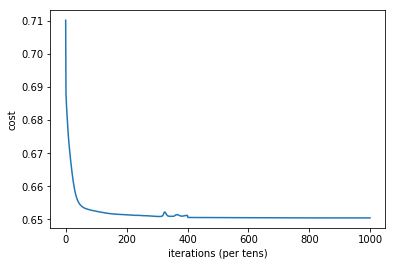

Parameters have been trained!
Train Accuracy: 0.6075499
Test Accuracy: 0.6009079
Neural network training time consumed: 218.302242 secs


In [59]:
## training and predict
tf.reset_default_graph()
start_time = time.time()
neural_num = [X_train.shape[0], 32, 16, 8, 4, 2]
# cost function of mini_batch may not decrease at each iteration
# not work: parameters = model(X_train, Y_train, X_test, Y_test, neural_num, num_epochs = 1500, learning_rate = 10**(-1))
figname = r'D:\wkspacePY\STA 141C\picture\nn5_feature_5000'
parameters = model(X_train, Y_train, X_test, Y_test, neural_num, num_epochs = 5000, learning_rate = 1,figname = figname)
end_time = time.time()
print("Neural network training time consumed: %lf secs" % (end_time - start_time))

In [44]:
## training and predict
tf.reset_default_graph()
start_time = time.time()
neural_num = [X_train.shape[0], 14, 12, 10, 8, 20, 18, 16, 6, 4, 2]
# cost function of mini_batch may not decrease at each iteration
# not work: parameters = model(X_train, Y_train, X_test, Y_test, neural_num, num_epochs = 1500, learning_rate = 10**(-1))
figname = r'D:\wkspacePY\STA 141C\picture\nn10_5000'
parameters = model(X_train, Y_train, X_test, Y_test, neural_num, num_epochs = 5000, learning_rate = 0.01, figname = figname, period = 5000)
end_time = time.time()
print("Neural network training time consumed: %lf secs" % (end_time - start_time))

Cost after epoch 0: 0.693387
Cost after epoch 100: 0.687279
Cost after epoch 200: 0.687304
Cost after epoch 300: 0.687303
Cost after epoch 400: 0.687303
Cost after epoch 500: 0.687303
Cost after epoch 600: 0.687303
Cost after epoch 700: 0.687303
Cost after epoch 800: 0.687303
Cost after epoch 900: 0.687303
Cost after epoch 1000: 0.687303


KeyboardInterrupt: 